In [1]:
import pandas as pd

In [44]:
collectionsheet=pd.read_excel("OCSEAN_initial_englishsheet.xlsx")
#collectionsheet=collectionsheet.set_index('Language_AsInFile')

In [41]:
joined_data=pd.read_excel("OCSEAN_initial_joineddata.xlsx")

In [42]:
joined_data.head()

,Unnamed: 0,Concept,Word,Language
0,0,sun,wariy,Abui_Bunggeta
1,1,moon,'uya,Abui_Bunggeta
2,2,star,furiy,Abui_Bunggeta
3,3,sky,'adiiy,Abui_Bunggeta
4,4,Earth,buku ~ bukuw,Abui_Bunggeta


In [47]:
# If collectionsheet doesn't already have 'Language', get it from joined_data
collectionsheet['Language'] = collectionsheet['Language'] #joined_data['Language'].drop_duplicates().values

In [48]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Step 1: Load your data (already in `joined_data`)

# Step 2: Create binary matrix: rows = Language, columns = Concept
# Fill 1 if a word is present, else 0
presence_matrix = joined_data.pivot_table(
    index="Language",
    columns="Concept",
    values="Word",
    aggfunc=lambda x: 1 if x.notna().any() else 0,
    fill_value=0
)

In [50]:
joined_data['Language'].unique()

array(['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang',
       'Abui_Pelman', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Arta',
       'Ata', 'Ati', 'Ba_a', 'Balangao', 'Bali_Aga', 'Balinese', 'Batak',
       'Bicolano', 'Boholano', 'Bolinao', 'Bontoc', 'Buhid', 'Bulus',
       'Chabacano_Caviteno', 'Cuyunon', 'Dela', 'Enggano', 'Gaddang',
       'Hanunuo', 'Hattang_Kaye', 'Hiligaynon_20220813',
       'Hiligaynon_20240802', 'Ilognon', 'Ilokano', 'Inabaknon',
       'Ivatan_Isabtangen', 'Ivatan_Ichbayatan', 'Kalinga', 'Kamayo',
       'Kankana_ey', 'Kapampangan', 'Kinaray_a', 'Kolibogon',
       'Kupang Malay', 'Kusa', 'Loloan_Malay', 'Manea', 'Manubo_Tasaday',
       'Mawes_Wares', 'Mawesdai', 'Meranaw', 'Minamanwa', 'Molbog', 'Obo',
       'Palawano', 'Pangasinan', 'Sabu_Raijua', 'Sabu_Seba', 'Sangil',
       'Sinama_Banguingui', 'Sinama_Sitangkai', 'Sinama_Tabawan',
       'Tagakaulo', 'Tagbanwa_Central', 'Talaandig', 'Tausug', 'Tboli',
       'Uab_Meto', 'Waray', 'Yakan'], dtyp

In [53]:
language_to_country = pd.DataFrame({
    'Language': joined_data['Language'].unique(),
    'COUNTRY': collectionsheet['COUNTRY'] 
})

In [57]:
# UMAP on the binary presence/absence matrix
reducer = umap.UMAP(metric="hamming", random_state=42)
embedding = reducer.fit_transform(presence_matrix)

/Users/madjl/GoogleDrive/University/OCSEAN-2025/RESEARCH/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/madjl/GoogleDrive/University/OCSEAN-2025/RESEARCH/.venv/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Users/madjl/GoogleDrive/University/OCSEAN-2025/RESEARCH/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [67]:
# Build DataFrame with embedding and language names
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
umap_df["Language"] = presence_matrix.index

# Merge with country info from collectionsheet
umap_df = umap_df.merge(collectionsheet[["Language", "COUNTRY"]], on="Language", how="left")

# Count number of missing concepts per language
umap_df['missing_count'] = (presence_matrix == 0).sum(axis=1).values/presence_matrix.shape[1]

In [68]:
#(presence_matrix == 0).sum(axis=1)
presence_matrix.shape

(68, 3092)

In [71]:
# Normalize missing_count to control marker sizes
umap_df['point_size'] = umap_df['missing_count']  # Adjust multiplier as needed

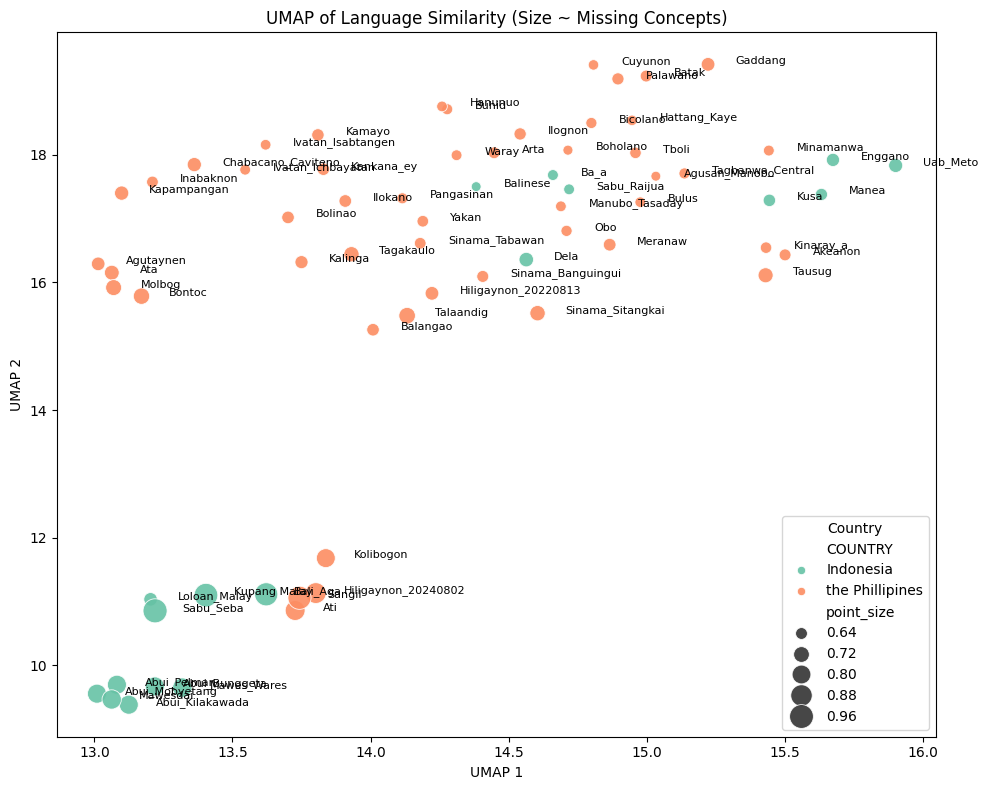

In [72]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="COUNTRY",
    size="point_size",
    sizes=(50, 300),  # Min and max size
    palette="Set2",
    alpha=0.9
)

# Optional: add labels
for _, row in umap_df.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["Language"], fontsize=8)

plt.title("UMAP of Language Similarity (Size ~ Missing Concepts)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Country", loc="best")
plt.tight_layout()
plt.show()